# 25 marks

In [36]:
# Import libraries

import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, zscore
from sklearn.datasets import fetch_california_housing
import pymc3 as pm
import arviz as az
from model_utils import preprocess_housing
from sklearn.preprocessing import StandardScaler
plt.rcParams.update({'font.size': 20})

In [83]:
# Load California housing dataset

california_housing = fetch_california_housing(as_frame=True)
x = california_housing.data
print(x.shape)
y = california_housing.target
print(y.shape)

(20640, 8)
(20640,)


In [84]:
print("Means:")
print(x.mean())

Means:
MedInc           3.870671
HouseAge        28.639486
AveRooms         5.429000
AveBedrms        1.096675
Population    1425.476744
AveOccup         3.070655
Latitude        35.631861
Longitude     -119.569704
dtype: float64


In [91]:
# Preprocess datapoints

X_train, X_test, y_train, y_test = preprocess_housing(x,y)

def standardiseCols(x):
    x_means = x.mean(axis=0)
    x_std = x.std(axis=0)
    return (x - x_means) / x_std

x = standardiseCols(x)

data has no null values
Removed 846 outlier rows
Target value counts: 5.00001    965
Name: MedHouseVal, dtype: int64
Removed 670 skewed rows


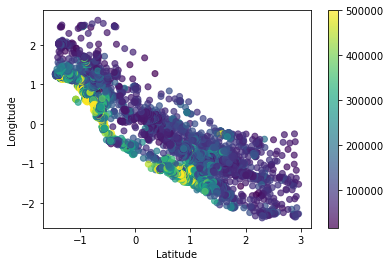

In [86]:
# Plot how longitude and latitude affect median house price

latitudes = x['Latitude']
longitudes = x['Longitude']
plt.scatter(latitudes, longitudes, c=y*100000, alpha=0.7)
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [87]:
# Run PyMC algorithm to get posterior distributions for each feature

num_samples = 1000
model = pm.Model()

with model:
    # Define priors
    intercept = pm.Normal('intercept', mu=0, sigma=20)
    MedInc = pm.Normal('MedInc', mu=0, sigma=20)
    HouseAge = pm.Normal('HouseAge', mu=0, sigma=20)
    AveRooms = pm.Normal('AveRooms', mu=0, sigma=20)
    AveBedrms = pm.Normal('AveBedrms', mu=0, sigma=20)
    Population = pm.Normal('Population', mu=0, sigma=20)
    AveOccup = pm.Normal('AveOccup', mu=0, sigma=20)
    Latitude = pm.Normal('Latitude', mu=0, sigma=20)
    Longitude = pm.Normal('Longitude', mu=0, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = intercept + MedInc*x["MedInc"] + HouseAge*x["HouseAge"] + AveRooms*x["AveRooms"] + AveBedrms*x["AveBedrms"] + Population*x["Population"] + AveOccup*x["AveOccup"] + Latitude*x["Latitude"] + Longitude*x["Longitude"]

    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y)
    
    sampler = pm.NUTS()
    
    idata = pm.sample(num_samples, sampler, progressbar=True, cores=4, chains=2)

/var/folders/8g/b7_xy_gx7ysgvrt10qyzhv7c0000gn/T/ipykernel_55529/2730354449.py:25: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  idata = pm.sample(num_samples, sampler, progressbar=True, cores=4, chains=2)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, Longitude, Latitude, AveOccup, Population, AveBedrms, AveRooms, HouseAge, MedInc, intercept]


/Users/lucy/opt/anaconda3/envs/ML_labs/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/lucy/opt/anaconda3/envs/ML_labs/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 187 seconds.


In [7]:
input_d = pickle.load(open('sampler_inference.pkl', 'rb'))

In [89]:
az.summary(idata, round_to=4)

/Users/lucy/opt/anaconda3/envs/ML_labs/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.0685,0.0048,2.0592,2.0773,0.0001,0.0001,2097.3776,1385.6139,1.0012
MedInc,0.8299,0.0080,0.8150,0.8449,0.0002,0.0001,1453.2020,1362.3994,1.0001
HouseAge,0.1186,0.0059,0.1076,0.1293,0.0001,0.0001,1919.1589,1679.5896,0.9999
AveRooms,-0.2660,0.0146,-0.2933,-0.2391,0.0004,0.0003,1314.9611,1185.7757,1.0016
AveBedrms,0.3058,0.0135,0.2809,0.3311,0.0004,0.0003,1332.8571,1157.9727,1.0032
Population,-0.0046,0.0053,-0.0142,0.0060,0.0001,0.0001,2044.6503,1632.8687,0.9995
AveOccup,-0.0394,0.0052,-0.0490,-0.0298,0.0001,0.0001,2256.3318,1410.7295,1.0022
Latitude,-0.8995,0.0155,-0.9257,-0.8678,0.0004,0.0003,1281.9776,1235.7584,1.0024
Longitude,-0.8701,0.0152,-0.8982,-0.8409,0.0004,0.0003,1372.6547,1224.2867,1.0012
sigma,0.7245,0.0035,0.7183,0.7312,0.0001,0.0001,2059.3689,1470.6011,0.9998


In [13]:
# Save pymc results in pkl format

pickle.dump(input_d.posterior, open("posteriors.pkl", "wb"))
pickle.dump(input_d.sample_stats, open("sample_stats.pkl", "wb"))
pickle.dump(input_d.observed_data, open("observed_data.pkl", "wb"))

In [38]:
# Load posteriors from pkl file

posteriors = pickle.load(open('posteriors.pkl', 'rb'))

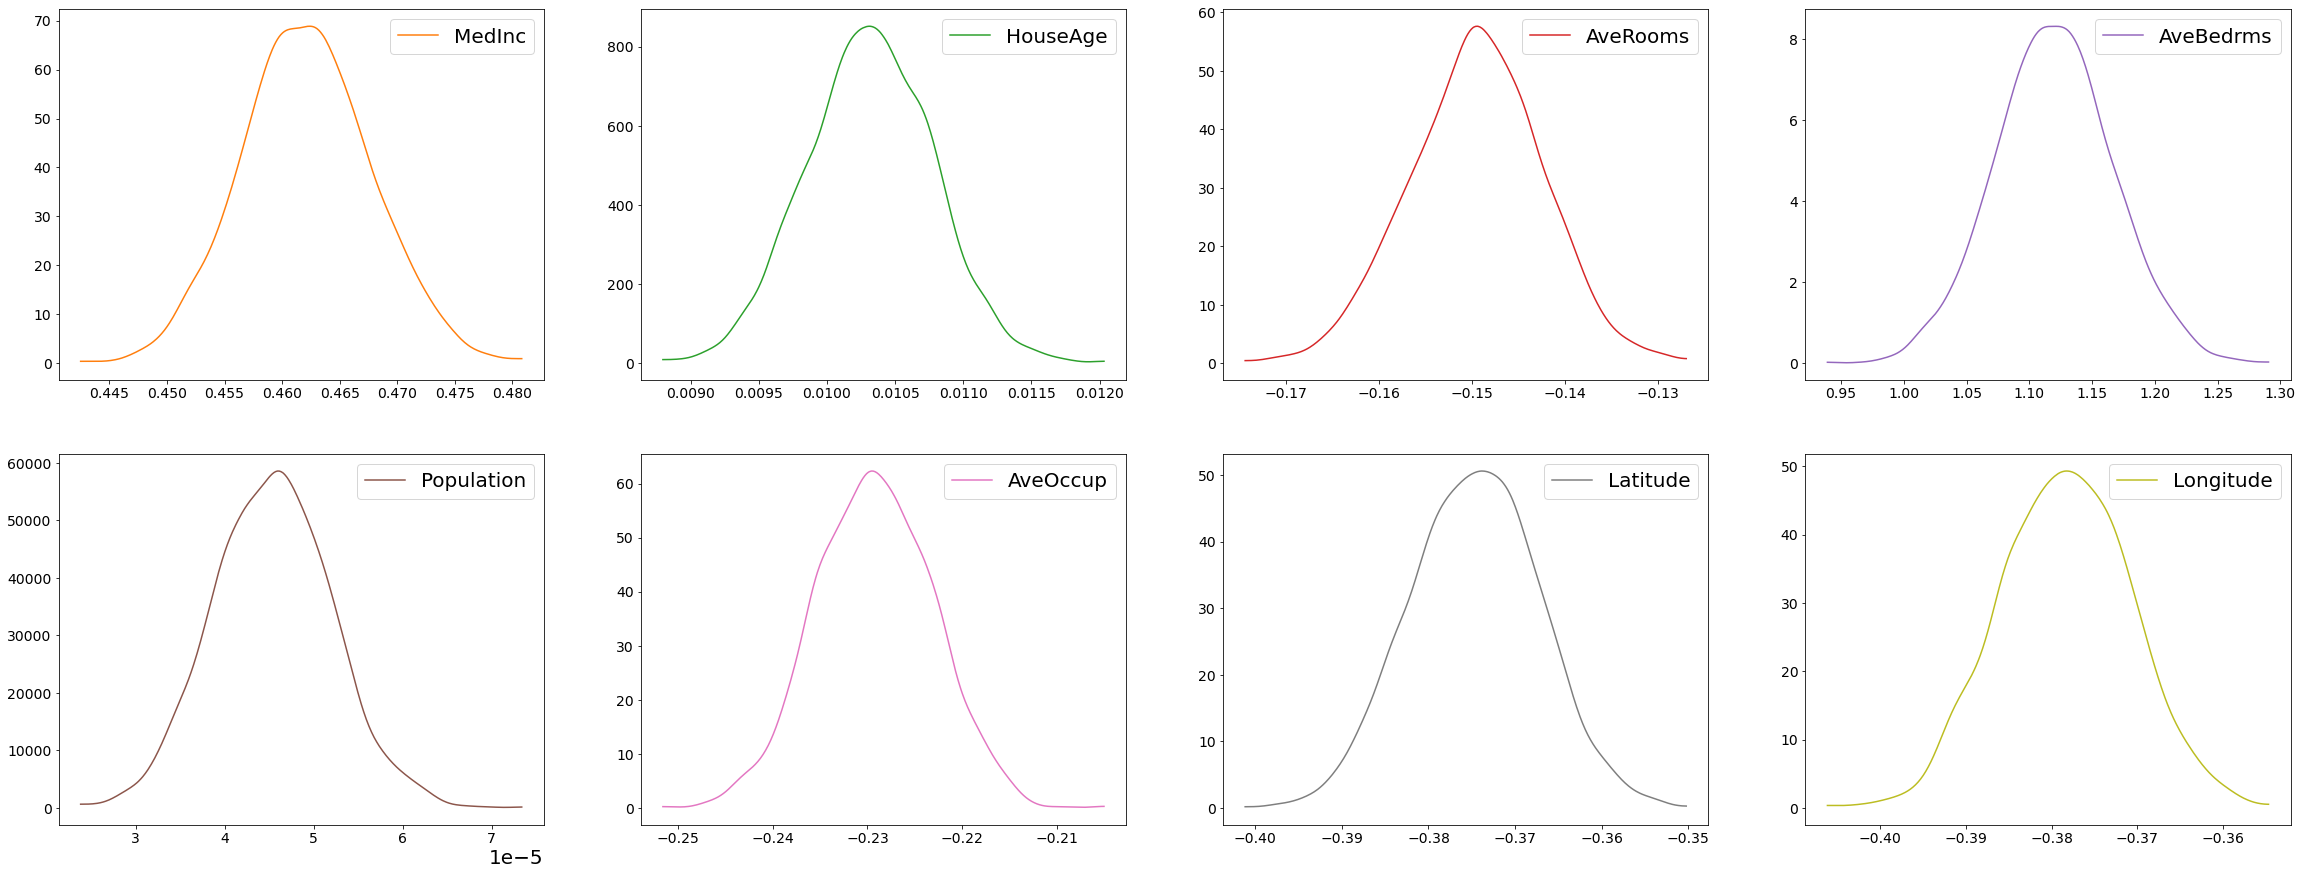

In [58]:
# Plot each posterior distribution

features = ["MedInc" ,"HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"]
posterior_names = ['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']

_, ax = plt.subplots(2, 4, figsize=(40, 15))
az.plot_dist(posteriors['w1'], color="C1", label="MedInc", ax=ax[0][0])
az.plot_dist(posteriors['w2'], color="C2", label="HouseAge", ax=ax[0][1])
az.plot_dist(posteriors['w3'], color="C3", label="AveRooms", ax=ax[0][2])
az.plot_dist(posteriors['w4'], color="C4", label="AveBedrms", ax=ax[0][3])
az.plot_dist(posteriors['w5'], color="C5", label="Population", ax=ax[1][0])
az.plot_dist(posteriors['w6'], color="C6", label="AveOccup", ax=ax[1][1])
az.plot_dist(posteriors['w7'], color="C7", label="Latitude", ax=ax[1][2])
az.plot_dist(posteriors['w8'], color="C8", label="Longitude", ax=ax[1][3])

plt.show()

In [108]:
with model:
    ppc = pm.sample_posterior_predictive(
        idata, var_names=["MedInc" ,"HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude", "y"]
    )

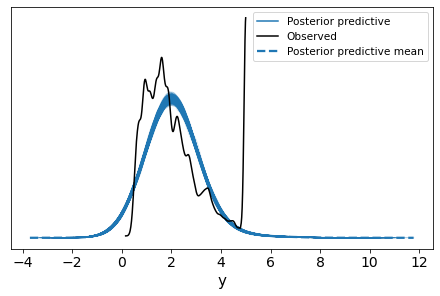

In [109]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));